# **👾 다음 분기 게임 설계 계획 👾**

1. 지역에 따라서 선호하는 게임 장르가 다를까
2. 연도별 게임의 트렌드가 있을까
3. 매출이 높은 게임에 대한 분석 및 시각화 프로세스



In [225]:
import pandas as pd
import seaborn as sns
import numpy as np

# 시각화
import seaborn as sns

import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.gridspec import GridSpec

import matplotlib.pyplot as plt
%matplotlib inline

# ANOVA
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
# Tukey's HSD test
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# 2 sample chi-test
from scipy.stats import chi2_contingency

# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## **1) 데이터 전처리**

---

데이터를 체크하면서 결측치 또는 잘못 입력된 값들을 찾아내어 수정한다.

In [5]:
# 데이터셋 불러오기
df = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/vgames2.csv', index_col=0)
df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
1,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
2,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
4,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04


In [6]:
# 데이터셋 정보 파악
df.info() 
df['Name'].value_counts() # 한 게임이 여러번 존재하는 경우는 서로 다른 플랫폼에서 제공되었기 때문이다.
df['Platform'].value_counts() # 이상 없어보임
df['Year'].value_counts() # 두자리수의 경우 수정 => 0-9까지는 앞에 2000 / 11-20까지는 앞에 20 / 그 이상은 19 붙이기
df['Genre'].value_counts() # 이상 없어보임
df['Publisher'].value_counts() # sold out => 항목이 하나이므로 찾아서 대체
print()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16598 entries, 1 to 16598
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16598 non-null  object 
 1   Platform     16598 non-null  object 
 2   Year         16327 non-null  float64
 3   Genre        16548 non-null  object 
 4   Publisher    16540 non-null  object 
 5   NA_Sales     16598 non-null  object 
 6   EU_Sales     16598 non-null  object 
 7   JP_Sales     16598 non-null  object 
 8   Other_Sales  16598 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.3+ MB



In [7]:
# 데이터 결측치 확인
new_df = df.copy()

new_df_na = new_df.isnull().sum()
new_df_na

Name             0
Platform         0
Year           271
Genre           50
Publisher       58
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
dtype: int64

👾 **총 9개의 column이 존재**

> 1. Name: 한 게임이 여러번 존재. => 서로 다른 플랫폼에서 제공되었기 때문. <br> (나중에 분석에 이용할수도?..) => 수정 필요 x
> 2. Platform: 수정 필요 x
> 3. Year
>     - 연도는 float이 아닌 int형으로 바꿔준다.
>     - 두자리 수 또는 한자리 수의 경우 수정
>         - 0-20까지는 2000 더해주기
>         - 21-99은 1900 더해주기
>     - N/A 처리: `replace_nan()` 후, 0으로 처리
> 4. Genre
>     - N/A 처리: `replace_nan()` 후, unknown으로 처리
> 5. Publisher
>     - sold out: 항목이 하나이므로 찾아서 대체 해주고, 
>     - unknown: N/A으로 바꾼 뒤, `replace_nan()` 후, unknown으로 처리
>     - N/A 처리: `replace_nan()` 후, unknown으로 처리
> 6. (   )_Sales 
>     - 판매량을 나타내는 column(NA_Sales, EU_Sales, JP_Sales, Other_Sales)들의 경우 object형으로 되어있다. 숫자에 문자형이 섞여있다는 것을 의미하므로 데이터를 체크해서 숫자만 있도록 통일해준다.
>     - M 또는 K가 없는 경우 단위는 M이다. -> K단위로 바꿔준다. => `make_k()`
>     - float형으로 데이터타입을 바꿔준다.


> 🌲 결측치 처리 <br>
> : 같은 이름이 있으면 해당 값으로 결측치 대체하는 함수를 생성하여 처리하고, 같은 이름을 가지는 게임이 없다면 unknown 또는 0으로 대체해준다.

**함수 선언**

In [8]:
# 같은 이름이 있으면 해당 값으로 결측치 대체하는 함수
# df : dataframe / column_name: string

def replace_nan(df, column_name):
  change_df = df['{}'.format(column_name)].copy() # 해당 칼럼만 복사
  change_df = change_df.isnull()                  # 결측치면 true

  i = 0
  j = 0
  for c in change_df:
    if c: # 만약 결측치이면
      the_name = df.at[df.index[i], 'Name'] # 결측치를 가지는 게임의 Name
      j = 0
      for n in df['Name']:
        if n == the_name: # 결측치를 가지는 게임의 Name과 같은 이름을 가지는 항목이 있으면, 
          df.at[df.index[i], column_name] = df.at[df.index[j], column_name] # 결측치를 가지는 게임의 해당 칼럼의 값을 동일 게임의 값으로 대체
        j += 1
    i+=1

# 인덱스 5713의 경우, 게임명은 Back to the Future: The Game이고 Genre가 결측치를 가진다.
# 하지만 동명 게임을 참조하여 Genre 값을 채우도록 한다.

In [9]:
# 판매량을 K단위로 환산해주는 함수
# 마지막 글자가 M이면 M을 지우고 1000을 곱해준다
# 아무 글자도 없으면 1000을 곱해준다
# 마지막 글자가 K이면 K를 지운다

# NA_Sales, EU_Sales, JP_Sales, Other_Sales

# df : dataframe / column_name : string

def make_k(df, column_name):
  i = 0
  for c in df['{}'.format(column_name)]:
    if (c[-1]).upper() == 'M':
      df.at[df.index[i], '{}'.format(column_name)] = float(c[:-1]) * 1000
    elif (c[-1]).upper() == 'K':
      df.at[df.index[i], '{}'.format(column_name)] = float(c[:-1])
    else:
      df.at[df.index[i], '{}'.format(column_name)] = float(c) * 1000
    i += 1
  df['{}'.format(column_name)] = pd.to_numeric(df['{}'.format(column_name)]) # float형으로 바꿔주기

In [10]:
df_edit = df.copy()

**'Year' 처리**

In [11]:
# Year 수정
# 0-20까지는 2000 더해주기 + 21-99은 1900 더해주기
i = 0
for y in df_edit['Year']:
  if y <= 20:
    df_edit.at[df.index[i], 'Year'] = 2000+y # 'Year' column 중 index가 i인 cell 선택하여 2000+y로 대체
  elif 10 < y < 100:
    df_edit.at[df.index[i], 'Year'] = 1900+y
  i += 1

In [12]:
replace_nan(df_edit, 'Year') # 동명 게임을 참조하여 year 대체

In [13]:
new_df = df_edit.copy()

new_df_na = new_df.isnull().sum()
new_df_na # Year에서 결측치가 271 -> 170으로 감소

Name             0
Platform         0
Year           170
Genre           50
Publisher       58
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
dtype: int64

In [14]:
# 남은 결측치는 0으로 대체해줌
df_edit['Year'] = df_edit['Year'].fillna(0)

# 확인
# df_edit['Year'].value_counts()

In [15]:
# data type을 int형으로 바꿔줌
df_edit['Year'] = df_edit['Year'].astype('int')
df_edit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16598 entries, 1 to 16598
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         16598 non-null  object
 1   Platform     16598 non-null  object
 2   Year         16598 non-null  int64 
 3   Genre        16548 non-null  object
 4   Publisher    16540 non-null  object
 5   NA_Sales     16598 non-null  object
 6   EU_Sales     16598 non-null  object
 7   JP_Sales     16598 non-null  object
 8   Other_Sales  16598 non-null  object
dtypes: int64(1), object(8)
memory usage: 1.9+ MB


**'Genre' 처리**

In [16]:
replace_nan(df_edit, 'Genre')

In [17]:
new_df = df_edit.copy()

new_df_na = new_df.isnull().sum()
new_df_na # 결측치 50 -> 30

Name            0
Platform        0
Year            0
Genre          30
Publisher      58
NA_Sales        0
EU_Sales        0
JP_Sales        0
Other_Sales     0
dtype: int64

In [18]:
df_edit['Genre'] = df_edit['Genre'].fillna('Unknown')

In [90]:
# df_edit[df_edit['Genre'] == 'Unknown']

**'Publisher' 처리**

In [19]:
# Sold out -> Team17 Software
df_edit.at[df.index[12905], 'Publisher']

'Sold Out'

In [20]:
# df_edit.at[df.index[12905], 'Publisher'] = 'Team17 Software'
# df_edit['Publisher'].value_counts()

In [21]:
# Unknown -> nan
df_edit['Publisher'] = df_edit['Publisher'].replace('Unknown', np.nan)

new_df = df_edit.copy()

new_df_na = new_df.isnull().sum()
new_df_na

Name             0
Platform         0
Year             0
Genre            0
Publisher      261
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
dtype: int64

In [22]:
 replace_nan(df_edit, 'Publisher')

In [23]:
new_df = df_edit.copy()

new_df_na = new_df.isnull().sum()
new_df_na # 결측치 261 -> 200

Name             0
Platform         0
Year             0
Genre            0
Publisher      200
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
dtype: int64

In [24]:
df_edit['Publisher'] = df_edit['Publisher'].replace(np.nan, 'Unknown')

new_df = df_edit.copy()

new_df_na = new_df.isnull().sum()
new_df_na

Name           0
Platform       0
Year           0
Genre          0
Publisher      0
NA_Sales       0
EU_Sales       0
JP_Sales       0
Other_Sales    0
dtype: int64

**'( )_Sales' 처리**

In [25]:
float('0.04')

0.04

In [26]:
sales = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']

for i in sales:
  make_k(df_edit, '{}'.format(i))


In [27]:
df_edit.head(11)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
1,Candace Kane's Candy Factory,DS,2008,Action,Destineer,40.0,0.0,0.0,0.0
2,The Munchables,Wii,2009,Action,Namco Bandai Games,170.0,0.0,0.0,10.0
3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0.0,0.0,20.0,0.0
4,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,40.0,0.0,0.0,0.0
5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,120.0,90.0,0.0,40.0
6,Power Pro Kun Pocket 8,DS,2005,Sports,Konami Digital Entertainment,0.0,0.0,140.0,0.0
7,JASF: Jane's Advanced Strike Fighters,PC,2011,Simulation,Deep Silver,20.0,10.0,0.0,0.0
8,Samurai Warriors: State of War,PSP,2005,Action,Tecmo Koei,70.0,0.0,110.0,10.0
9,Imabikisou,PS3,2007,Adventure,Sega,0.0,0.0,40.0,0.0
10,The Penguins of Madagascar: Dr. Blowhole Retur...,PS3,2011,Action,THQ,40.0,30.0,0.0,10.0


In [28]:
df_edit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16598 entries, 1 to 16598
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16598 non-null  object 
 1   Platform     16598 non-null  object 
 2   Year         16598 non-null  int64  
 3   Genre        16598 non-null  object 
 4   Publisher    16598 non-null  object 
 5   NA_Sales     16598 non-null  float64
 6   EU_Sales     16598 non-null  float64
 7   JP_Sales     16598 non-null  float64
 8   Other_Sales  16598 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 1.9+ MB


##**2) 지역에 따라서 선호하는 게임 장르가 다를까**
---
> 1. Genre별로 묶어서 지역별 판매량 평균내서 시각화하여 비교
> 2. Genre별 판매량의 평균이 통계적으로 유의미한 차이가 나는지 확인 (ANOVA + Tuckey's HSD)


**Genre별 판매량 평균 + 시각화**

**함수 선언**

In [29]:
# Genre별로 묶어서 지역별 판매량 평균내고 한 df로 만드는 함수
# sales_list : 지역명이 담긴 리스트

def Genre_mean(sales_list):
  merged_Genre_mean = pd.DataFrame()
  i = 0
  for s in sales_list:
    df_G = df_edit[['Genre', '{}'.format(s)]] # 데이터 불러오기
    df_G_mean = df_G.groupby(['Genre'], as_index=False).mean() # 장르별 평균
    if i == 0: # 처음에는 새로운 df에 그냥 저장
      merged_Genre_mean = df_G_mean.copy() 
    else:      # 두번째부터는 merge
      merged_Genre_mean = merged_Genre_mean.merge(df_G_mean,how = 'outer', on = ['Genre']) 
    i += 1
  return merged_Genre_mean

In [31]:
sales = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
merged_Genre_mean = Genre_mean(sales)

# column명 나라이름으로 바꾸기
country = ['North America', 'Europe', 'Japan', 'Other']

for i in range(len(country)):
  merged_Genre_mean = merged_Genre_mean.rename(columns={'{}'.format(sales[i]): '{}'.format(country[i]) })

merged_Genre_mean

,Genre,North America,Europe,Japan,Other
0,Action,264.527047,158.201874,47.718344,56.440012
1,Adventure,82.418097,49.976599,40.561622,13.112324
2,Fighting,263.667453,119.481132,103.007075,43.254717
3,Misc,235.325648,122.420749,60.674352,42.685879
4,Platform,504.553672,227.819209,147.627119,58.237288
5,Puzzle,213.408304,87.768166,98.391003,21.660900
6,Racing,287.905297,190.930979,45.264848,61.966292
7,Role-Playing,215.468645,123.789616,232.602832,38.408631
8,Shooter,444.732824,239.137405,29.221374,78.389313
9,Simulation,211.270208,130.923788,73.556582,36.362587


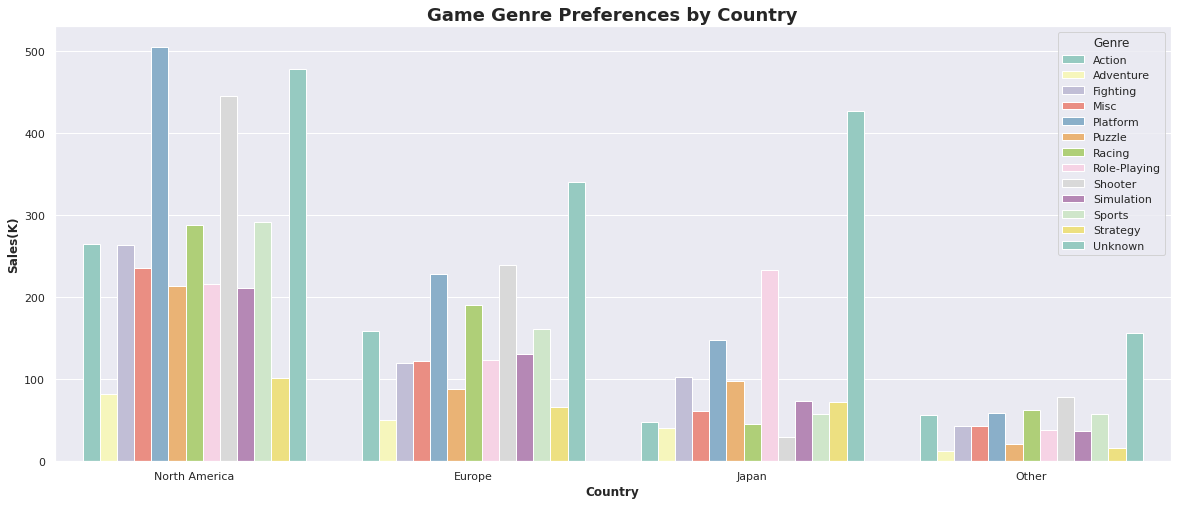

In [33]:
# tidy
merged_Genre_mean_tidy = merged_Genre_mean.melt(id_vars='Genre', value_vars=['North America', 'Europe', 'Japan', 'Other'])
merged_Genre_mean_tidy.head()

# 시각화
fig = plt.figure()
genre_scat = fig.add_subplot(1, 1, 1)

sns.set(rc={'figure.figsize':(20,8)})
sns.barplot(data = merged_Genre_mean_tidy, x = 'variable', y = 'value', hue = 'Genre', palette="Set3");

genre_scat.set_title('Game Genre Preferences by Country', weight='bold').set_fontsize('18')
plt.ylabel('Sales(K)', weight='bold')
plt.xlabel('Country', weight='bold')

plt.show()

👾 **시각화 결과**
- North America
> 1위: Platform <br>
> 2위: Shooter <br>
> 3위: Sports <br>
> 4위: Racing
  - 3, 4위는 근소한 차이 => 유의미한가?
- Europe
> 1위: Shooter <br>
> 2위: Platform <br>
> 3위: Racing <br>
> 4위: Sports
  - 상위 4개 모두 근소한 차이 => 유의미한지 확인
- Japan
> 1위: Role-Playing <br>
> 2위: Platform <br>
> 3위: Fighting <br>
> 4위: Puzzle
  - 미국, 유럽과는 아주 다른 양상을 보이고 있음. 동서양의 문화적 차이인가?



---


**통계분석 (ANOVA + Tuckey's HSD)** 

**함수 선언**

In [34]:
# df : DataFrame / factor : string / level : list

# One-way ANOVA
# ANOVA 후, 귀무가설을 채택하는지 기각하는지 출력해주는 함수
def one_ANOVA(df, factor, level):
  for i in range(len(level)):
    model = ols('{} ~ C({})'.format(level[i], factor), df).fit()
    m = anova_lm(model)
    print('< one_ANOVA : {} >\n'.format(level[i]), m)
    m.reset_index() # 인덱스 리셋
    p = m.at[m.index[0], 'PR(>F)']
    if  p < 0.05:
      print(' ** Reject H0 **')
    else:
      print(' ** Selecte H0 **')
    print()
    print()


In [35]:
# df : DataFrame
# factor : string
# level : string
# country : 'North America', 'Europe', 'Japan', 'Other' : string

# Tuckey's HSD  
# Tuckey's HSD 사후분석 후, 유의미한 차이가 있는 그룹만 출력하고 나라별 그래프를 시각화해주는 함수
def Tuckey_HSD(df, factor, level, tidy, country):
  # Tuckey's HSD
  hsd = pairwise_tukeyhsd(df_edit[level], df_edit['{}'.format(factor)], alpha=0.05)
  model = hsd.summary()
  df_hsd = pd.read_html(model.as_html())[0] # statsmodels.iolib.table.simpletable -> dataframe
  print("< Tuckey's HSD : {} >".format(level))

  i = 0
  for c in df_hsd['reject']:
    if c == True:
      g1 = df_hsd.at[df_hsd.index[i], 'group1']
      g2 = df_hsd.at[df_hsd.index[i], 'group2']
      print('    {} - {}'.format(g1, g2)) # , end=' / '
    i += 1
  print()

  # 시각화(simultaneous)
  # fig = plt.figure()
  fig = hsd.plot_simultaneous()
  plt.xlim(-100, 1000) # x축 범위
  fig

  # 시각화(barplot)
  # tidy = merged_Genre_mean.melt(id_vars='Genre', value_vars=['{}'.format(country)])
  # tidy = tidy.sort_values('value', ascending=False)

  # fig = plt.figure()
  # genre_scat_co = fig.add_subplot(1, 1, 1)

  # sns.barplot(data = tidy, x = 'variable', y = 'value', hue = 'Genre', palette="Set3");

  # genre_scat_co.set_title('Game Genre Preferences in {}'.format(country), weight='bold')
  # plt.ylabel('Sales(K)', weight='bold')
  # plt.xlabel('Country', weight='bold')

  # plt.show()
  print()

In [36]:
tidy = merged_Genre_mean.melt(id_vars='Genre', value_vars=['North America'])
tidy
tidy.sort_values('value')

,Genre,variable,value
1,Adventure,North America,82.418097
11,Strategy,North America,101.029412
9,Simulation,North America,211.270208
5,Puzzle,North America,213.408304
7,Role-Playing,North America,215.468645
3,Misc,North America,235.325648
2,Fighting,North America,263.667453
0,Action,North America,264.527047
6,Racing,North America,287.905297
10,Sports,North America,291.283035


**👾 One-way ANOVA**

나라 별 선호하는 게임 장르의 차이가 유의미한지 확인한다.
> 귀무가설: 이 나라에서 판매된 게임의 장르 별 매출액의 평균이 동일하다.<br>
> 대안가설: 이 나라에서 판매된 게임의 장르 별 매출액의 평균 중 적어도 한 장르는 다른 장르들과 다르다. 

In [37]:
level = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
one_ANOVA(df_edit, 'Genre', level)

< one_ANOVA : NA_Sales >
                df        sum_sq       mean_sq          F        PR(>F)
C(Genre)     12.0  1.669605e+08  1.391338e+07  21.164672  4.926376e-47
Residual  16585.0  1.090276e+10  6.573868e+05        NaN           NaN
 ** Reject H0 **


< one_ANOVA : EU_Sales >
                df        sum_sq       mean_sq         F        PR(>F)
C(Genre)     12.0  4.247272e+07  3.539393e+06  13.98949  1.886849e-29
Residual  16585.0  4.196067e+09  2.530037e+05       NaN           NaN
 ** Reject H0 **


< one_ANOVA : JP_Sales >
                df        sum_sq       mean_sq          F         PR(>F)
C(Genre)     12.0  5.497461e+07  4.581217e+06  49.572116  2.035227e-117
Residual  16585.0  1.532706e+09  9.241520e+04        NaN            NaN
 ** Reject H0 **


< one_ANOVA : Other_Sales >
                df        sum_sq        mean_sq          F        PR(>F)
C(Genre)     12.0  5.297756e+06  441479.660448  12.516474  6.941763e-26
Residual  16585.0  5.849843e+08   35271.888463       

> ANOVA 결과 테이블에서 Pr(>F)는 p-value를 뜻한다. 북미, 유럽, 일본 모두에서 p-value가 0.05 이하로 **귀무가설을 기각**하였다. 따라서 `각 지역에서 판매된 게임의 장르 별 매출액의 평균 중 적어도 한 장르는 다른 장르들과 다르다`는 결론이 나왔다. 즉, 위에서 시각화한 그래프는 유의미하다는 것이다. 하지만 ANOVA 결과만으로는 실제로 어떤 장르 사이에서 유의미한 차이가 있는지 확인할 수 없다. 구체적으로 어떤 장르 사이에서 평균 차이가 나는지를 검증하기 위해 사후분석(Tuckey's HSD 이용)을 실시한다.

**👾 Tuckey's HSD**

< Tuckey's HSD : NA_Sales >
    Action - Adventure
    Action - Platform
    Action - Shooter
    Action - Strategy
    Adventure - Fighting
    Adventure - Misc
    Adventure - Platform
    Adventure - Racing
    Adventure - Role-Playing
    Adventure - Shooter
    Adventure - Simulation
    Adventure - Sports
    Fighting - Platform
    Fighting - Shooter
    Fighting - Strategy
    Misc - Platform
    Misc - Shooter
    Misc - Strategy
    Platform - Puzzle
    Platform - Racing
    Platform - Role-Playing
    Platform - Simulation
    Platform - Sports
    Platform - Strategy
    Puzzle - Shooter
    Racing - Shooter
    Racing - Strategy
    Role-Playing - Shooter
    Shooter - Simulation
    Shooter - Sports
    Shooter - Strategy
    Sports - Strategy




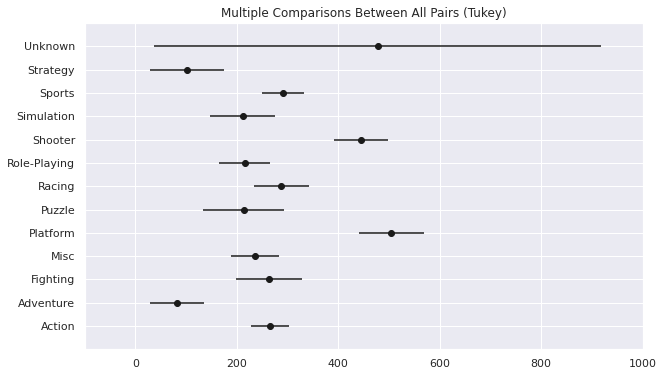

In [38]:
# North America
Tuckey_HSD(df_edit, 'Genre', 'NA_Sales', merged_Genre_mean_tidy, 'North America')

Tuckey's HSD 결과를 종합해보면, 게임 장르 별 매출액(=선호도)를 세 그룹으로 나누어 분류해볼 수 있다.
각 그룹 안에서 매출액이 가장 낮은 장르와 매출액이 가장 높은 장르 사이에 유의미한 차이가 있는 것을 기준으로 나누었다.

> - 그룹 1 (선호도 상): Platform, Shooter
> - 그룹 2 (선호도 중): Action, Fighting, Misc, Puzzle, Racing, Role-Playing, Simulation, Sports
> - 그룹 3 (선호도 하): Adventure, Strategy

다른 지역에 비해 비교적 명확하게 세 그룹으로 나뉘는 것을 볼 수 있다.

< Tuckey's HSD : EU_Sales >
    Action - Adventure
    Action - Platform
    Action - Shooter
    Action - Strategy
    Adventure - Misc
    Adventure - Platform
    Adventure - Racing
    Adventure - Role-Playing
    Adventure - Shooter
    Adventure - Simulation
    Adventure - Sports
    Fighting - Platform
    Fighting - Shooter
    Misc - Platform
    Misc - Racing
    Misc - Shooter
    Platform - Puzzle
    Platform - Role-Playing
    Platform - Simulation
    Platform - Sports
    Platform - Strategy
    Puzzle - Racing
    Puzzle - Shooter
    Racing - Role-Playing
    Racing - Strategy
    Role-Playing - Shooter
    Shooter - Simulation
    Shooter - Sports
    Shooter - Strategy
    Sports - Strategy




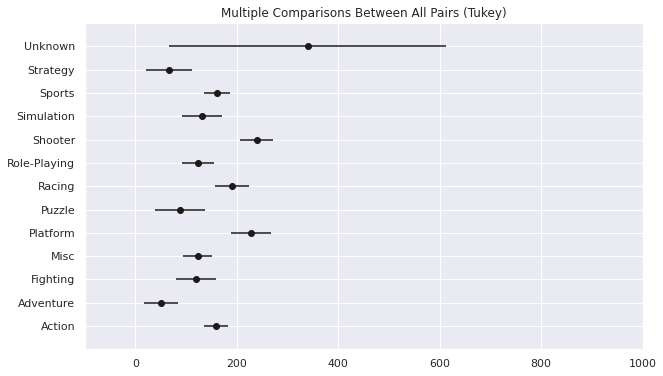

In [39]:
# Europe
Tuckey_HSD(df_edit, 'Genre', 'EU_Sales', merged_Genre_mean_tidy, 'Europe')

Tuckey's HSD 결과를 종합해보면, 북미에 비해 게임 장르 별 매출액을 뚜렷하게 나눌 수 없다. 그 이유에는 북미에서 소비되는 게임의 규모가 유럽보다 더 크기 때문일 수도 있다. 그래프가 북미에 비해 왼쪽에 몰려있는 것을 볼 수 있다. 북미와 마찬가지로 Platform, Shooter에서 강세를 보이고 있다. 더불어 Racing 비교적 높은 매출액에 속한다.

> - 그룹 1 (선호도 상): Platform, Shooter, Racing
> - 그룹 2 (선호도 중): Action, Fighting, Misc, Puzzle, Role-Playing, Simulation, Sports
> - 그룹 3 (선호도 하): Adventure, Strategy

< Tuckey's HSD : JP_Sales >
    Action - Fighting
    Action - Platform
    Action - Puzzle
    Action - Role-Playing
    Action - Unknown
    Adventure - Fighting
    Adventure - Platform
    Adventure - Puzzle
    Adventure - Role-Playing
    Adventure - Unknown
    Fighting - Misc
    Fighting - Racing
    Fighting - Role-Playing
    Fighting - Shooter
    Fighting - Sports
    Fighting - Unknown
    Misc - Platform
    Misc - Role-Playing
    Misc - Unknown
    Platform - Racing
    Platform - Role-Playing
    Platform - Shooter
    Platform - Simulation
    Platform - Sports
    Platform - Strategy
    Platform - Unknown
    Puzzle - Racing
    Puzzle - Role-Playing
    Puzzle - Shooter
    Puzzle - Unknown
    Racing - Role-Playing
    Racing - Unknown
    Role-Playing - Shooter
    Role-Playing - Simulation
    Role-Playing - Sports
    Role-Playing - Strategy
    Role-Playing - Unknown
    Shooter - Simulation
    Shooter - Unknown
    Simulation - Unknown
    Sports - Unknown


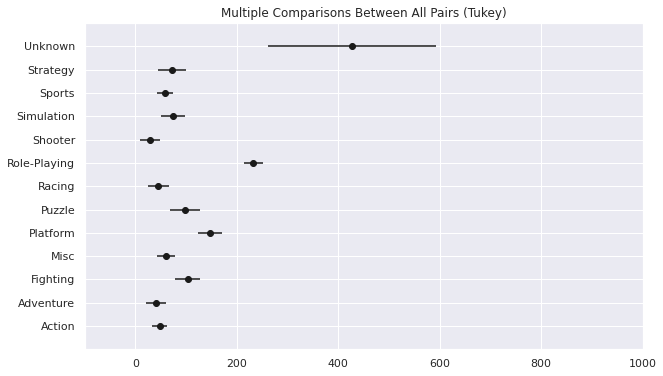

In [40]:
# Japan
Tuckey_HSD(df_edit, 'Genre', 'JP_Sales', merged_Genre_mean_tidy, 'Japan')

일본의 경우 북미, 유럽과는 확연히 다른 양상을 보인다. 미국과 유럽의 경우 선호도 중간 정도에 머물렀던 Role-Playing이 독보적으로 높은 매출액을 보이는 것을 알 수 있다. 또한 Platform이 뒤를 이었다. 다른 장르들은 서로 유의미한 차이를 보이지 않았다.

< Tuckey's HSD : Other_Sales >
    Action - Adventure
    Action - Puzzle
    Action - Shooter
    Action - Strategy
    Adventure - Fighting
    Adventure - Misc
    Adventure - Platform
    Adventure - Racing
    Adventure - Role-Playing
    Adventure - Shooter
    Adventure - Sports
    Adventure - Unknown
    Fighting - Shooter
    Misc - Shooter
    Platform - Puzzle
    Platform - Strategy
    Puzzle - Racing
    Puzzle - Shooter
    Puzzle - Sports
    Puzzle - Unknown
    Racing - Strategy
    Role-Playing - Shooter
    Role-Playing - Unknown
    Shooter - Simulation
    Shooter - Strategy
    Simulation - Unknown
    Sports - Strategy
    Strategy - Unknown




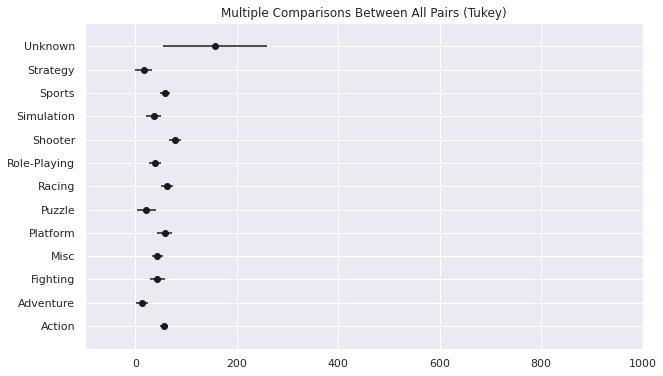

In [41]:
# Other
Tuckey_HSD(df_edit, 'Genre', 'Other_Sales', merged_Genre_mean_tidy, 'Other')

**👾 결론**
1. 지역별로 게임 매출액에서 다른 양상을 보인다. 
2. 세 지역 중 북미가 게임 소비시장이 크다.
3. 북미와 유럽은 Platform, Shooter를 가장 선호하는 비슷한 선호도 양상을 보인다.
4. 동양국가인 일본은 Role-Playing에 대한 선호도가 가장 큰, 서양과는 확연히 다른 양상을 보인다. 하지만 동양국가의 표본은 일본 한 곳 뿐이기 때문에 동양의 성향이라고 보기 어렵다. 

##**3) 연도별 게임의 트렌드가 있을까**
---

연도별 게임의 트렌드를 살펴보기 위해 연도별로 어떤 장르의 게임이 많이 출시되었는지, 어떤 장르의 게임의 매출액이 높은지 살펴보자.

In [42]:
# 모든 지역 매출액 합계 df
sum_sales = df_edit[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]
sum_sales = pd.DataFrame(sum_sales.sum(axis=1), columns=['Sales_sum'])
sum_sales

# 연도, 장르 df
year_genre = df_edit[['Year', 'Genre']].copy()
year_genre['Sales_sum'] = sum_sales

# 연도별 출시된 게임을 장르별로 count
g_year_genre_count = year_genre.groupby(['Year', 'Genre']).Genre.agg('count').to_frame('Count')
g_year_genre_count = g_year_genre_count.reset_index(drop = False)

# 연도별 출시된 게임들의 장르별 매출액의 합
g_year_genre_sum =  year_genre.groupby(['Year', 'Genre']).Sales_sum.agg('sum').to_frame('Sales_sum')
g_year_genre_sum = g_year_genre_sum.reset_index(drop = False)

# 합치기
merged_trend = g_year_genre_count.merge(g_year_genre_sum, how = 'outer', on = ['Year', 'Genre'])

# 결측치 제외
merged_trend_fin = merged_trend[merged_trend.Year != 0]
merged_trend_fin = merged_trend_fin[merged_trend_fin.Genre != 'Unknown']
merged_trend_fin

,Year,Genre,Count,Sales_sum
12,1980,Action,1,340.0
13,1980,Fighting,1,770.0
14,1980,Misc,4,2700.0
15,1980,Shooter,2,7070.0
16,1980,Sports,1,500.0
...,...,...,...,...
412,2016,Sports,38,14630.0
413,2016,Strategy,10,520.0
414,2017,Action,1,10.0
415,2017,Role-Playing,2,40.0


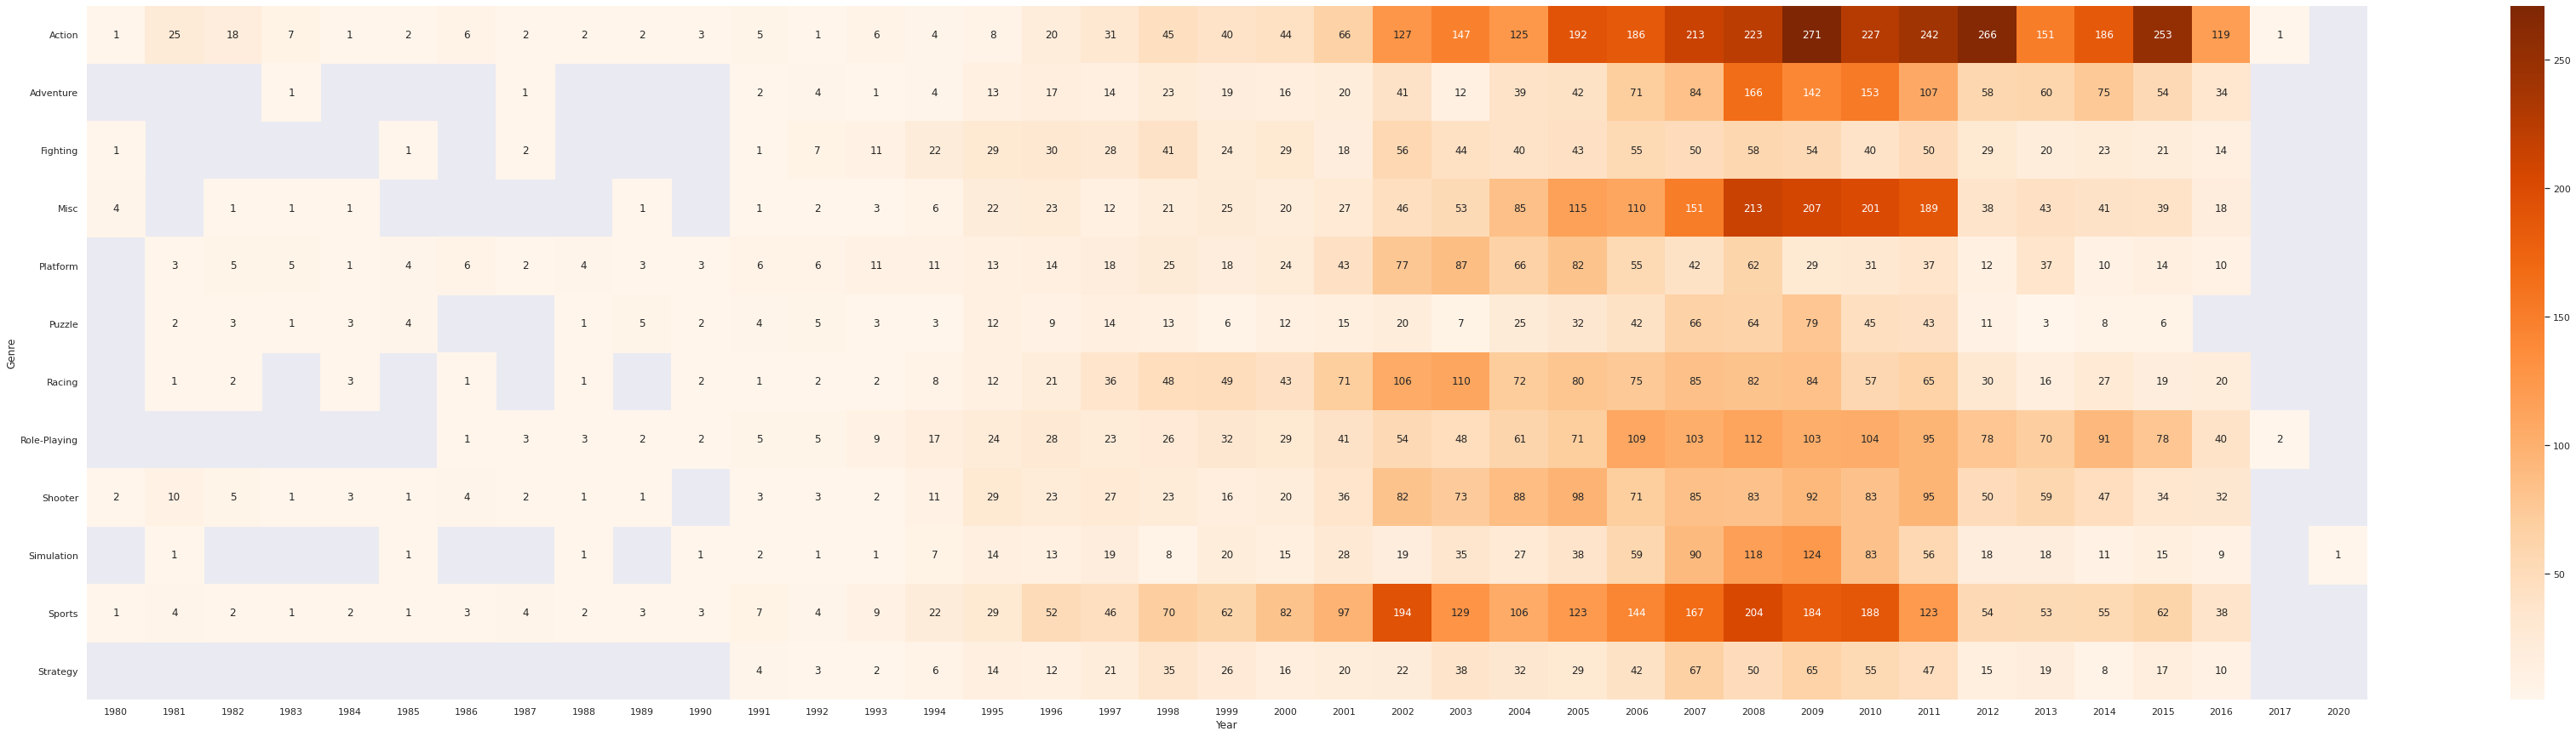

In [44]:
# 연도-장르별 출시된 게임의 개수 비교 시각화(heatmap 이용) 
fig = plt.figure()

trend_heatmap_count = merged_trend_fin.pivot('Year', 'Genre', 'Count')
trend_heatmap_count = trend_heatmap_count.transpose() # 행열 바꾸기

sns.set(rc={'figure.figsize':(60, 15)})
ax = sns.heatmap(trend_heatmap_count, annot=True, cmap='Oranges', fmt='g') 
# annot=True: 맵 위에 숫자 표시 / linewidths=.5 : 칸 사이에 공간 / fmt='g': e-notation을 일반표기법으로
ax

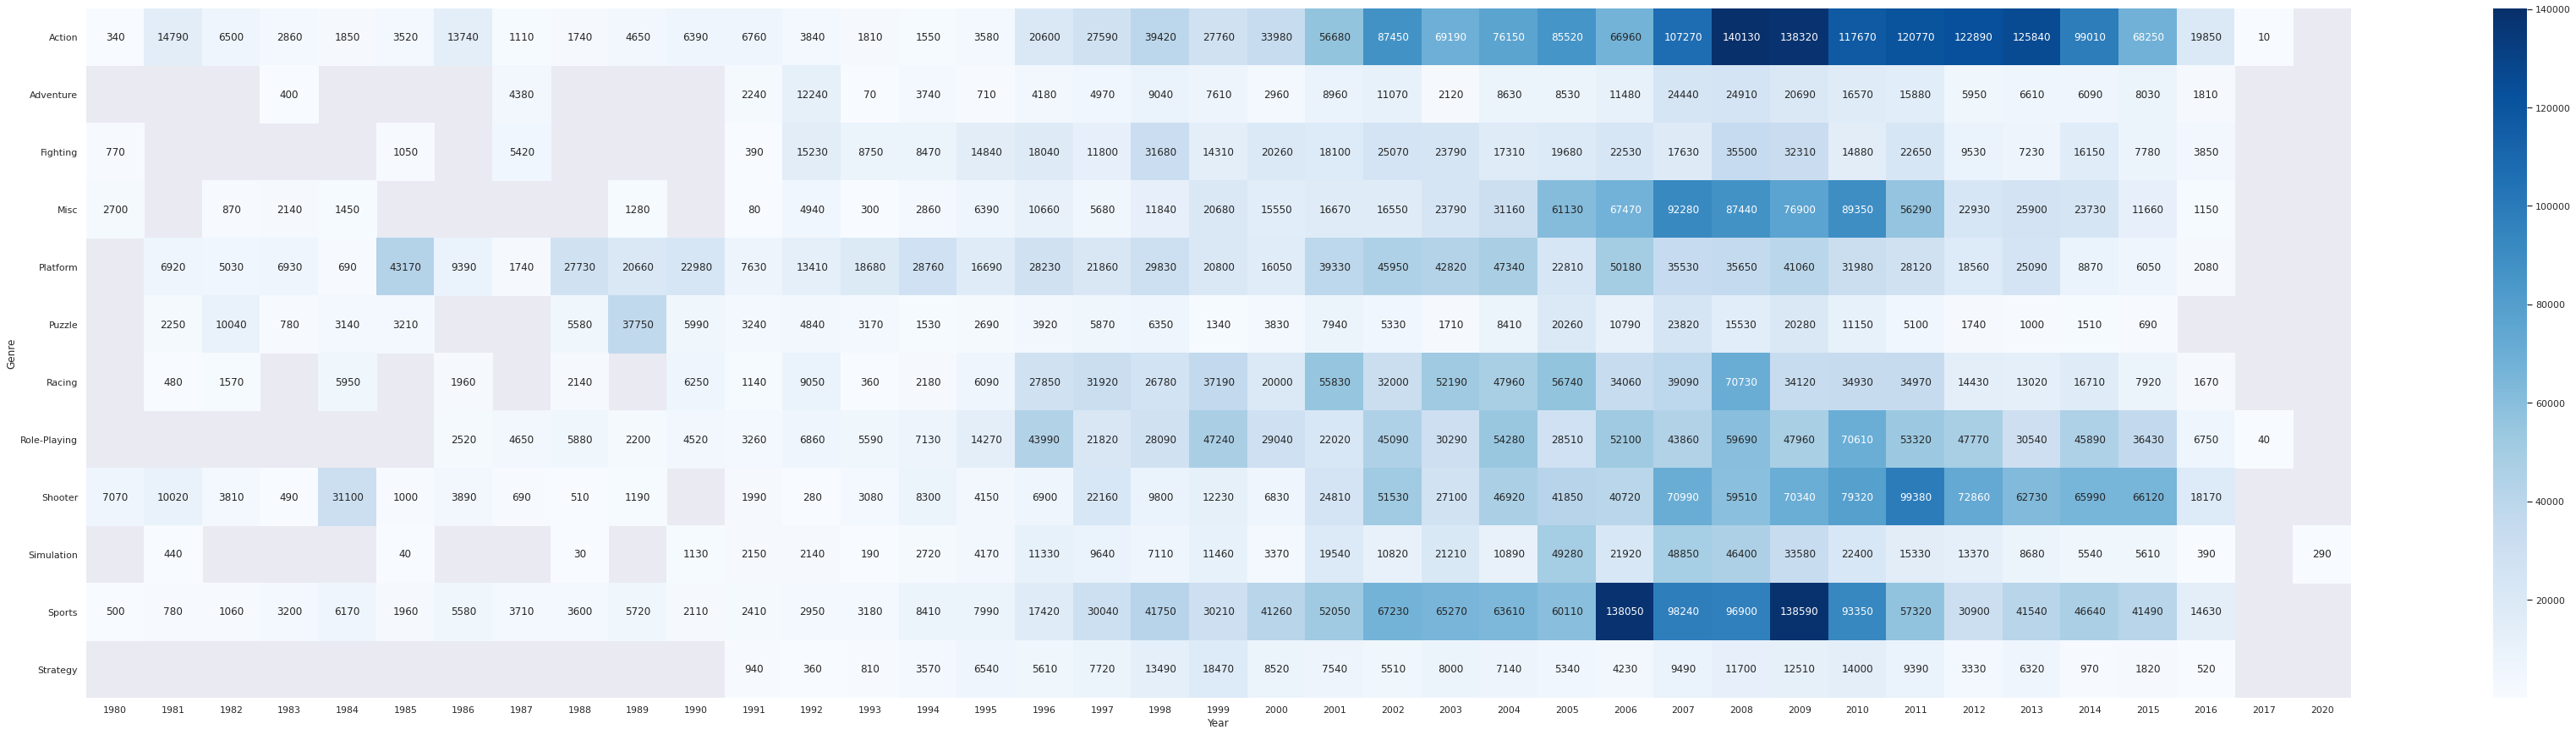

In [45]:
# 연도-장르별 매출액 비교 시각화(heatmap 이용) 
fig = plt.figure()

trend_heatmap_sum = merged_trend_fin.pivot('Year', 'Genre', 'Sales_sum')
trend_heatmap_sum = trend_heatmap_sum.transpose() # 행열 바꾸기

sns.set(rc={'figure.figsize':(60, 15)})
ax = sns.heatmap(trend_heatmap_sum, annot=True, cmap='Blues', fmt='g') 
# annot=True: 맵 위에 숫자 표시 / linewidths=.5 : 칸 사이에 공간 / fmt='g': e-notation을 일반표기법으로
ax

In [ ]:
# 장르별 출시된 게임 수 대비 매출액
# 매출액 / 게임수
# 값이 클수록 출시된 게임은 적은데 매출
# 분산이 클수록 

# 위 차트에서 한 게임이 독점적으로 높은 매출액을 기록했는가? 아니면 대체적으로 고르게?
# 2006 - Sports / 2009 - Sports
# 2008 - Action / 2009 - Action
# 어떻게 알아볼까? => 분산

In [ ]:
# 모든 지역의 매출액의 합산을 새로운 칼럼으로 추가
df_edit_salessum = df_edit.copy()
df_edit_salessum['Sales_sum'] = sum_sales

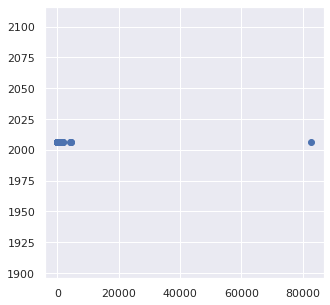

In [213]:
Sports_2006 = df_edit_salessum[(df_edit_salessum['Year'] == 2006) & (df_edit_salessum['Genre'] == 'Sports')]

sns.set(rc={'figure.figsize':(5, 5)})
plt.scatter(Sports_2006.Sales_sum, Sports_2006.Year)

In [214]:
Sports_2006[(Sports_2006['Sales_sum'] > 80000)]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Sales_sum
2909,Wii Sports,Wii,2006,Sports,Nintendo,41490.0,29020.0,3770.0,8460.0,82740.0


In [216]:
merged_trend_fin[(merged_trend_fin['Year'] == 2006) & (merged_trend_fin['Genre'] == 'Sports')]

,Year,Genre,Count,Sales_sum
284,2006,Sports,144,138050.0


In [218]:
82740/138050*100

59.93480622962694

2006년 Sports 장르에서 매출액의 59%를 하나의 게임이 차지 -> 트렌드라고 볼 수 있는가?

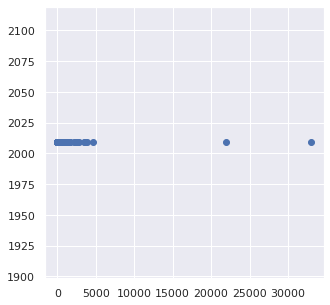

In [211]:
Sports_2009 = df_edit_salessum[(df_edit_salessum['Year'] == 2009) & (df_edit_salessum['Genre'] == 'Sports')]

sns.set(rc={'figure.figsize':(5, 5)})
plt.scatter(Sports_2009.Sales_sum, Sports_2009.Year)

In [212]:
Sports_2009[(Sports_2009['Sales_sum'] > 20000)]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Sales_sum
3353,Wii Sports Resort,Wii,2009,Sports,Nintendo,15750.0,11010.0,3280.0,2960.0,33000.0
10900,Wii Fit Plus,Wii,2009,Sports,Nintendo,9090.0,8590.0,2530.0,1790.0,22000.0


In [219]:
merged_trend_fin[(merged_trend_fin['Year'] == 2009) & (merged_trend_fin['Genre'] == 'Sports')]

,Year,Genre,Count,Sales_sum
323,2009,Sports,184,138590.0


In [220]:
33000.0/138590.0*100

23.81124179233711

**👾 결론**

action, Sports, Role Playing, Shooter가 꾸준히 인기가 있다.
누적 매출액이기 때문에 최근에 출시된 게임의 경우 누적액이 적을 수 있다.

##**4) 매출이 높은 게임에 대한 분석 및 시각화 프로세스**


---


In [181]:
# 모든 지역의 매출액의 합산을 새로운 칼럼으로 추가
df_edit_salessum = df_edit.copy()
df_edit_salessum['Sales_sum'] = sum_sales

# 총 매출액 기준 오름차순으로 정렬
sales_ascending = df_edit_salessum.sort_values(['Sales_sum'], ascending=False)
sales_ascending = sales_ascending.reset_index(drop=True)

# 총 매출액 중 가장 높은 매출을 기록한 500개의 게임만 따로 뽑아서 만듦
top_500_games = sales_ascending.head(500)
top_500_games.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Sales_sum
0,Wii Sports,Wii,2006,Sports,Nintendo,41490.0,29020.0,3770.0,8460.0,82740.0
1,Super Mario Bros.,NES,1985,Platform,Nintendo,29080.0,3580.0,6810.0,770.0,40240.0
2,Mario Kart Wii,Wii,2008,Racing,Nintendo,15850.0,12880.0,3790.0,3310.0,35830.0
3,Wii Sports Resort,Wii,2009,Sports,Nintendo,15750.0,11010.0,3280.0,2960.0,33000.0
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11270.0,8890.0,10220.0,1000.0,31380.0


In [47]:
# top 500 중 publisher가 unknown인 것이 한개라 직접 데이터를 채워줌
top_500_games['Publisher'] = top_500_games['Publisher'].replace('Unknown', 'THQ')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [180]:
# 출판사 별로 게임 나누기
by_publisher = top_500_games.groupby(['Publisher', 'Name']).count()
# by_publisher = pd.DataFrame(by_publisher)
by_publisher = by_publisher.reset_index()
by_publisher = by_publisher.drop(['Platform', 'Year',	'Genre',	'NA_Sales',	'EU_Sales',	'JP_Sales',	'Other_Sales',	'Sales_sum'], axis = 1)
# by_publisher = by_publisher.set_index(['Publisher', 'Name']) # 계층적 인덱스
by_publisher.head()

,Publisher,Name
0,505 Games,Cooking Mama
1,505 Games,Cooking Mama 2: Dinner With Friends
2,505 Games,Cooking Mama: Cook Off
3,505 Games,Zumba Fitness
4,Acclaim Entertainment,WWF War Zone


In [179]:
by_publisher['Publisher'].unique() # 유일한 값 찾기
count_by_publisher = pd.DataFrame(by_publisher['Publisher'].value_counts()) # 유일한 값별 개수 세기
count_by_publisher = count_by_publisher.reset_index()
count_by_publisher = count_by_publisher.rename(columns={'index': 'Publisher', 'Publisher': 'the number'})
count_by_publisher.head()

,Publisher,the number
0,Nintendo,132
1,Electronic Arts,52
2,Sony Computer Entertainment,52
3,Activision,30
4,Microsoft Game Studios,22


(-1.0, 33.0)

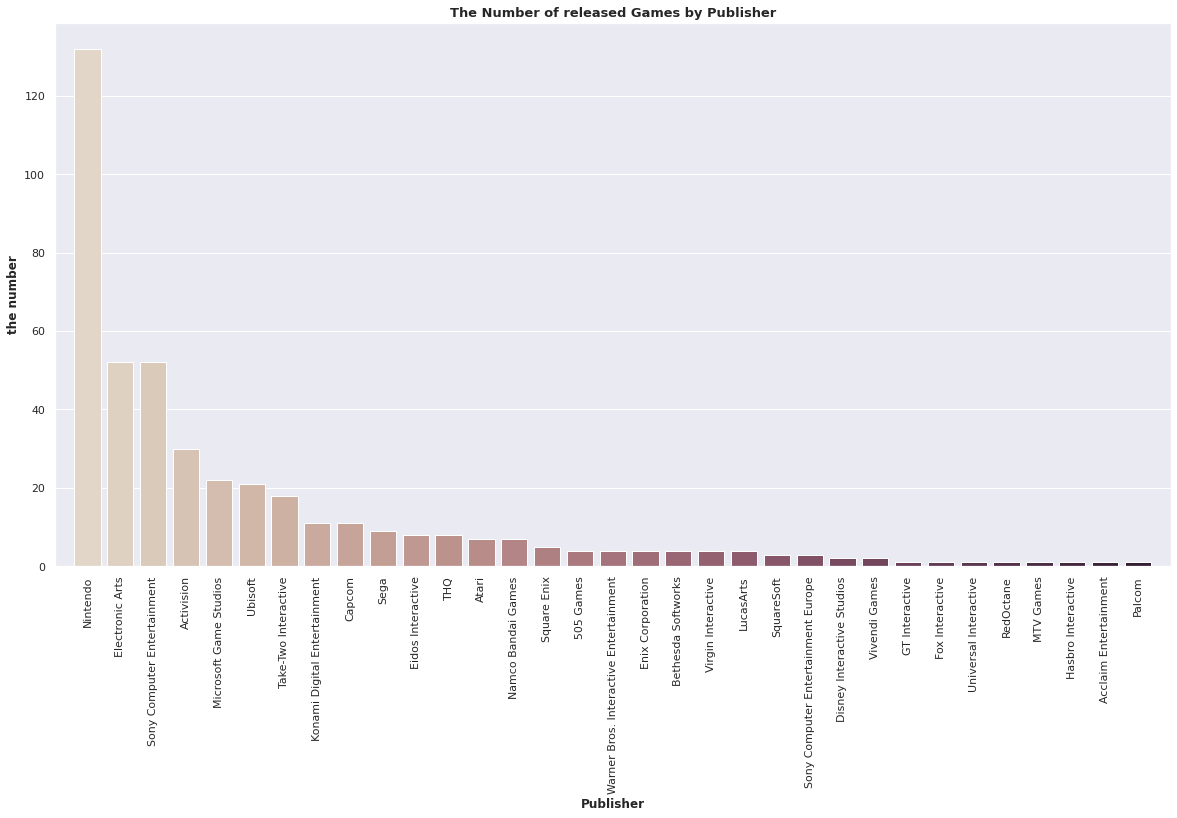

In [178]:
# 시각화 (barplot)
fig = plt.figure()
pub_bar = fig.add_subplot(1, 1, 1)


sns.set(rc={'figure.figsize':(20, 10)})
sns.barplot(x="Publisher", y = 'the number', palette="ch:.25", data=count_by_publisher)

pub_bar.set_title('The Number of released Games by Publisher', weight='bold').set_fontsize('13')
plt.xticks(rotation = 90 )

plt.ylabel('the number', weight='bold')
plt.xlabel('Publisher', weight='bold')

plt.xlim(-1, 33)

In [170]:
# 발매된 게임의 개수가 8개 이하인 출판사는 other로 묶기

less_3 = count_by_publisher[(count_by_publisher['the number'] <= 8)] # 8개 이하인 row 선택
sum_less = less_3['the number'].sum() # other에 해당하는 게임 개수

count_by_publisher_new = count_by_publisher.drop(less_3.index) # 삭제

other_publisher = {'Publisher': 'Other', 'the number': sum_less} 
count_by_publisher_new = count_by_publisher_new.append(other_publisher, ignore_index=True) # 추가

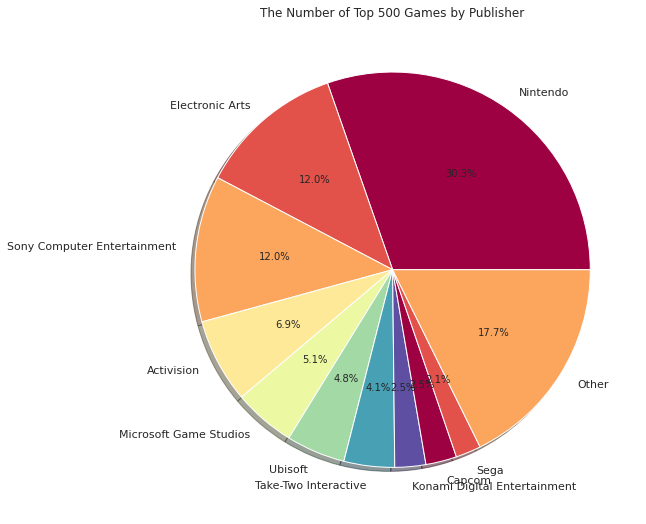

In [174]:
# 시각화 (pie plot)
plt.figure(1, figsize=(20,20))
the_grid = GridSpec(2, 2)

cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 8)]

plt.subplot(the_grid[0, 1], aspect=1, title='The Number of Top 500 Games by Publisher')

publisher_pie = plt.pie(count_by_publisher_new['the number'], labels=count_by_publisher_new['Publisher'], autopct='%1.1f%%', shadow=True, colors=colors)

plt.show()

In [182]:
top_500_games_sales = top_500_games[['NA_Sales',	'EU_Sales',	'JP_Sales',	'Other_Sales']]
top_500_games_sales.head()

,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,41490.0,29020.0,3770.0,8460.0
1,29080.0,3580.0,6810.0,770.0
2,15850.0,12880.0,3790.0,3310.0
3,15750.0,11010.0,3280.0,2960.0
4,11270.0,8890.0,10220.0,1000.0


**👾 결론**

특정 회사가 제작한 게임이 매출액을 높게 기록한다. <br>
=> 소비자의 브랜드 충성도로 볼 수 있을까?